# Rustで整数を5バイトに押し込む簡単なお仕事

## はじめに

Rustで整数を40bitでストレージに読み書きする方法について調べました。[以前の記事](https://)でGo言語で同じことをやっています。

まずは、Rustをインストールします。

In [ ]:
!wget https://static.rust-lang.org/rustup/rustup-init.sh
!sh rustup-init.sh -y
!cp /root/.cargo/bin/* /usr/local/bin

検証用のプロジェクトを作成して、カレントディレクトリを移動します。

In [3]:
!cargo new measure
%cd measure

     Created binary (application) `measure` package
/content/measure


環境設定ファイルを生成します。

In [4]:
%%writefile Cargo.toml

[package]
name = "measure"
version = "0.1.0"
authors = []
edition = "2018"

[dependencies]
rand = "0.8.4"

Overwriting Cargo.toml


## 64bit整数の8バイト配列化

> `to_le_bytes()`がおすすめ

まずは64bitの整数をバイト配列にする方法を調べます。(以下では整数のエンコーディングはリトルエンディアンにします。特にunsafeがらみではビックエンディアンのCPUでは間違った動作になりますのでご注意ください。)

愚直だとこうでしょうか。
```
for j in 0..8 {
    buf[j] = (v >> (8 * j)) as u8;
}
```

In [97]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);

    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }
    let mut buf: [[u8; 8]; SIZE] = [[0; 8]; SIZE];

    // 計測開始
    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i % SIZE;
        let v = vs[idx];
        let b = &mut buf[idx];
        for j in 0..8 {
            b[j] = (v >> (8 * j)) as u8;
        }
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..8 {
            total += buf[i][j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [98]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.53s
     Running `target/release/measure`
11.795 sec
[205, 178, 63, 42, 187, 0, 0, 0]
63749253


速い。Go言語では同じ処理で2分以上かかっていました。オプティマイザが優秀そうです。

ここで、参考のため、時間測定外の処理をなくして計測してみます。

In [120]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }
    let mut buf: [[u8; 8]; SIZE] = [[0; 8]; SIZE];

    // 計測開始
    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i % SIZE;
        let v = vs[idx];
        let b = &mut buf[idx];
        for j in 0..8 {
            b[j] = (v >> (8 * j)) as u8;
        }
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

}


Overwriting src/main.rs


In [121]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.50s
     Running `target/release/measure`
0.000 sec


計算結果を出力しないと、最適化で処理が削除されてしまうようです。また、計算結果の全てに触らないと部分的に削除されることもあるようなので、念のため全てに触るようにしてあります。


それでは内側のfor文を展開してみましょう。

In [75]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }
    let mut buf: [[u8; 8]; SIZE] = [[0; 8]; SIZE];

    // 計測開始
    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i % SIZE;
        let v = vs[idx];
        let b = &mut buf[idx];
        b[0] = v as u8;
        b[1] = (v >> 8) as u8;
        b[2] = (v >> 16) as u8;
        b[3] = (v >> 24) as u8;
        b[4] = (v >> 32) as u8;
        b[5] = (v >> 40) as u8;
        b[6] = (v >> 48) as u8;
        b[7] = (v >> 56) as u8;
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..8 {
            total += buf[i][j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [76]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.55s
     Running `target/release/measure`
11.777 sec
[205, 178, 63, 42, 187, 0, 0, 0]
63749253


ほぼ同じです。すでに最適化によりfor文が展開済みなのかもしれません。


Rustでは整数に対してto_le_bytes()というそのものズバリの関数が用意されていました。それを使用してみます。

In [12]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }
    let mut buf: [[u8; 8]; SIZE] = [[0; 8]; SIZE];

    // 計測開始
    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i % SIZE;
        buf[idx] = vs[idx].to_le_bytes();
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..8 {
            total += buf[i][j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [13]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.57s
     Running `target/release/measure`
7.133 sec
[205, 178, 63, 42, 187, 0, 0, 0]
63749253


かなり速くなりました。

次に、整数をバイト配列に変換する別の方法が[某書籍](https://www.amazon.co.jp/dp/B087BZQ48R)で紹介されていたので、試してみます。

In [14]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }
    let mut buf: [[u8; 8]; SIZE] = [[0; 8]; SIZE];

    // 計測開始
    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i % SIZE;
        unsafe {
            buf[idx] = std::mem::transmute::<u64, [u8; 8]>(vs[idx]);
        }
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..8 {
            total += buf[i][j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [15]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.53s
     Running `target/release/measure`
7.170 sec
[205, 178, 63, 42, 187, 0, 0, 0]
63749253


処理時間、ほぼ同じです。

どうせunsafeを使うなら、最後に、ポインターを使う技を試してみましょう。当初、どう型を定義してよいかわからず、コンパイラーに随分怒られました。

In [ ]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }
    let buf: [[u8; 8]; SIZE] = [[0; 8]; SIZE];

    // 計測開始
    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i % SIZE;
        unsafe {
            let ptr: *mut u64 = buf[idx].as_ptr() as *mut u64;
            *ptr = vs[idx];
        }
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..8 {
            total += buf[i][j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [ ]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.58s
     Running `target/release/measure`
7.242 sec
[205, 178, 63, 42, 187, 0, 0, 0]
63749253


誤差の範囲内で同じです。`to_le_bytes()`をおすすめします。

## 8バイト配列から64bit整数への変換

> `from_le_bytes()`がおすすめ



まずは愚直な方法です。

In [77]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 8]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    // 計測開始
    let start = Instant::now();
    let mut v: u64 = 0;
    for i in 0..COUNT {
        let b = buf[(i % SIZE) as usize];
        for j in 0..8 {
            v += (b[j] as u64) << (8 * j);
        }
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", v);
}

Overwriting src/main.rs


In [78]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.60s
     Running `target/release/measure`
24.457 sec
8845746833903097824


配列への変換に比べるとかなり遅いです。分解するよりも合成する方が計算が必要な分、遅くなるのでしょうか。

内側のfor文を展開します。

In [79]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 8]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    // 計測開始
    let start = Instant::now();
    let mut v: u64 = 0;
    for i in 0..COUNT {
        let b = buf[(i % SIZE) as usize];
        v += b[0] as u64;
        v += (b[1] as u64) << 8;
        v += (b[2] as u64) << 16;
        v += (b[3] as u64) << 24;
        v += (b[4] as u64) << 32;
        v += (b[5] as u64) << 40;
        v += (b[6] as u64) << 48;
        v += (b[7] as u64) << 56;
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", v);
}

Overwriting src/main.rs


In [80]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.58s
     Running `target/release/measure`
31.003 sec
8845746833903097824


~~25%ほど処理時間が短くなりました。内側の処理が複雑なので、最適化によるfor文の展開はなされていなかったようです。~~

逆に展開した方が処理時間が長くなる結果になりました。展開するよりも効率の良い最適化がなされるようになったのかもしれません。

次に、関数を使いましょう。

In [83]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 8]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    // 計測開始
    let start = Instant::now();
    let mut v: u64 = 0;
    for i in 0..COUNT {
        v += u64::from_le_bytes(buf[(i % SIZE) as usize]);
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", v);
}

Overwriting src/main.rs


In [84]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.65s
     Running `target/release/measure`
19.501 sec
8845746833903097824


速くなりました。流石に専用の関数は違いますね。

別の関数による方法。

In [85]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 8]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    // 計測開始
    let start = Instant::now();
    let mut v: u64 = 0;
    for i in 0..COUNT {
        unsafe {
            v += std::mem::transmute::<[u8; 8], u64>(buf[(i % SIZE) as usize]);
        }
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", v);
}

Overwriting src/main.rs


In [86]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.58s
     Running `target/release/measure`
19.346 sec
8845746833903097824


同じです。

次はunsafeを使った方法。

In [87]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 8]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    // 計測開始
    let start = Instant::now();
    let mut v: u64 = 0;
    for i in 0..COUNT {
        unsafe {
            v += *(buf[(i % SIZE) as usize].as_ptr() as *mut u64);
        }
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", v);
}

Overwriting src/main.rs


In [88]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.60s
     Running `target/release/measure`
19.390 sec
8845746833903097824


特に速くはなりませんでした。`from_le_bytes()`をお勧めします。

## 40bit整数の5バイト配列化

> `*(buf[idx..].as_ptr() as *mut u64) = v`が最速

それでは、本題の40bit整数を扱う方法を検討しましょう。
まずは愚直な方法です。

In [107]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);

    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }
    let mut buf: [[u8; 5]; SIZE] = [[0; 5]; SIZE];

    // 計測開始
    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i %SIZE;
        let v = vs[idx];
        let b = &mut buf[idx];
        for j in 0..5 {
            b[j] = (v >> (8 * j)) as u8;
        }
    }
    let end = start.elapsed();
    // 計測終了

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..5 {
            total += buf[i][j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [108]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.54s
     Running `target/release/measure`
22.381 sec
[205, 178, 63, 42, 187]
63749253


驚くことに、内側のforループが8回から5回に減っているにもかかわらず、64bit整数の8バイト配列化よりも処理時間が長くなりました。どうやら8回限定の超絶最適化が存在するようです。

内側のforループを展開するとどうなるでしょうか。

In [109]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }

    let mut buf: [[u8; 5]; SIZE] = [[0; 5]; SIZE];

    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i % SIZE;
        let v = vs[idx];
        let b = &mut buf[idx];
        b[0] = v as u8;
        b[1] = (v >> 8) as u8;
        b[2] = (v >> 16) as u8;
        b[3] = (v >> 24) as u8;
        b[4] = (v >> 32) as u8;
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..5 {
            total += buf[i][j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [110]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.53s
     Running `target/release/measure`
22.303 sec
[205, 178, 63, 42, 187]
63749253


これは変わりませんでした。

次に関数利用です。

In [122]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }
    let mut buf: [[u8;5]; SIZE] = [[0; 5]; SIZE];

    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i % SIZE;
        let dst = &mut buf[idx];
        let src = vs[idx].to_le_bytes();
        for j in 0..5 {
            dst[j] = src[j];
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..5 {
            total += buf[i][j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [123]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.53s
     Running `target/release/measure`
11.357 sec
[205, 178, 63, 42, 187]
63749253


かなり速くなりました。

別の関数ではどうでしょうか。

In [124]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }
    let mut buf: [[u8;5]; SIZE] = [[0; 5]; SIZE];

    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i % SIZE;
        unsafe {
            let dst = &mut buf[idx];
            let src = std::mem::transmute::<u64, [u8; 8]>(vs[idx]);
            for j in 0..5 {
                dst[j] = src[j];
            }
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..5 {
            total += buf[i][j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [125]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.54s
     Running `target/release/measure`
11.211 sec
[205, 178, 63, 42, 187]
63749253


同じでした。

次はポインター利用です。

In [126]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }
    let mut buf: [[u8;5]; SIZE] = [[0; 5]; SIZE];

    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i % SIZE;
        let v = vs[idx];
        let b = &mut buf[idx];
        unsafe {
            *(b.as_ptr() as *mut u32) = v as u32;
            b[4] = (v >> 32) as u8;
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..5 {
            total += buf[i][j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [127]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.54s
     Running `target/release/measure`
10.668 sec
[205, 178, 63, 42, 187]
63749253


少し速くなりました。

型変換に関数を使ってみます。

In [128]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }
    let mut buf: [[u8; 5]; SIZE] = [[0; 5]; SIZE];

    let start = Instant::now();
    for i in 0..COUNT {
        let idx = i % SIZE;
        let v = vs[idx];
        let b = &mut buf[idx];
        unsafe {
            *(b.as_ptr() as *mut u32) = v as u32;
            b[4] = std::mem::transmute::<u64, [u8; 8]>(v)[4];
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..5 {
            total += buf[i][j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [129]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.55s
     Running `target/release/measure`
10.604 sec
[205, 178, 63, 42, 187]
63749253


同じでした。

## 5バイト配列から40bit整数への変換

> `u64::from_le_bytes() & 0xFF_FFFF_FFFF`がおすすめ

まずは愚直な方法

In [134]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 5]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    let start = Instant::now();
    let mut total: u64 = 0;
    for i in 0..COUNT {
        let b = buf[(i % SIZE) as usize];
        let mut v = 0;
        for j in 0..5 {
            v += (b[j] as u64) << (8 * j);
        }
        total += v;
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", total);
}

Overwriting src/main.rs


In [135]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.59s
     Running `target/release/measure`
23.175 sec
1666958173003018432


for文の展開

In [130]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 5]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    let start = Instant::now();
    let mut total: u64 = 0;
    for i in 0..COUNT {
        let b = buf[(i % SIZE) as usize];
        let mut v = b[0] as u64;
        v += (b[1] as u64) << 8;
        v += (b[2] as u64) << 16;
        v += (b[3] as u64) << 24;
        v += (b[4] as u64) << 32;
        total += v;
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", total);
}

Overwriting src/main.rs


In [131]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.57s
     Running `target/release/measure`
23.188 sec
1666958173003018432


こちらはfor文を展開しても処理時間は変わりませんでした。

次に関数利用

In [136]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 8]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  0 as u8, 0 as u8, 0 as u8])
    }

    let start = Instant::now();
    let mut total: u64 = 0;
    for i in 0..COUNT {
        total += u64::from_le_bytes(buf[i % SIZE]) & 0xFF_FFFF_FFFF;
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", total);
}

Overwriting src/main.rs


In [137]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.59s
     Running `target/release/measure`
19.736 sec
1666958173003018432


少し速くなりました。

40bitに切り詰めるのに別の方法を使ってみます。

In [138]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 5]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    let start = Instant::now();
    let mut total: u64 = 0;
    for i in 0..COUNT {
        let b = &buf[i % SIZE];
        total += u64::from_le_bytes([b[0], b[1], b[2], b[3], b[4], 0, 0, 0]);
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", total);
}

Overwriting src/main.rs


In [139]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.61s
     Running `target/release/measure`
23.203 sec
1666958173003018432


遅くなりました。

さらに別の方法。

In [140]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 5]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    let start = Instant::now();
    let mut total: u64 = 0;
    for i in 0..COUNT {
        let b = buf[i % SIZE];
        total += u32::from_le_bytes([b[0], b[1], b[2], b[3]]) as u64 + ((b[4] as u64) << 32);
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", total);
}

Overwriting src/main.rs


In [141]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.59s
     Running `target/release/measure`
23.502 sec
1666958173003018432


遅いです。

さらに別の方法。

In [142]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 5]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    let start = Instant::now();
    let mut total: u64 = 0;
    for i in 0..COUNT {
        let b = buf[i % SIZE];
        unsafe {
            let ptr: *mut u32 = b.as_ptr() as *mut u32;
            total += (*ptr as u64) + ((b[4] as u64) << 32);
        }
    }
    let end = start.elapsed();


    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", total);
}

Overwriting src/main.rs


In [143]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.60s
     Running `target/release/measure`
27.194 sec
1666958173003018432


遅いです。

ポインターを使った方法を試します。

まずは0xFF_FFFF_FFFFマスクを使った方法。

In [144]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 8]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  0 as u8, 0 as u8, 0 as u8]);
    }

    let start = Instant::now();
    let mut total: u64 = 0;
    for i in 0..COUNT {
        let b = buf[i % SIZE];
        unsafe {
            let ptr: *mut u64 = b.as_ptr() as *mut u64;
            total += *ptr & 0xFF_FFFF_FFFF;
        }
    }
    let end = start.elapsed();


    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", total);
}

Overwriting src/main.rs


In [145]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.58s
     Running `target/release/measure`
19.383 sec
1666958173003018432


速くなりました。どうやらこれが最速のようです。

以下、その他の切り詰め方法。

In [146]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 5]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8]);
    }

    let start = Instant::now();
    let mut total: u64 = 0;
    for i in 0..COUNT {
        let b = buf[i % SIZE];
        let b = [b[0], b[1], b[2], b[3], b[4], 0, 0, 0];
        unsafe {
            total += *(b.as_ptr() as *mut u64);
        }
    }
    let end = start.elapsed();


    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", total);
}

Overwriting src/main.rs


In [147]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.58s
     Running `target/release/measure`
23.207 sec
1666958173003018432


遅い。

In [148]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 5]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    let start = Instant::now();
    let mut total: u64 = 0;
    for i in 0..COUNT {
        let b = buf[i % SIZE];
        total += u64::from_le_bytes([b[0], b[1], b[2], b[3], b[4], 0, 0, 0]);
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", total);
}

Overwriting src/main.rs


In [149]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.59s
     Running `target/release/measure`
23.126 sec
1666958173003018432


遅い。

In [150]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 10_000_000_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut buf: Vec<[u8; 5]> = Vec::new();
    for _ in 0..SIZE {
        buf.push([rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8,
                  rng.gen_range(0..256) as u8])
    }

    let start = Instant::now();
    let mut total: u64 = 0;
    for i in 0..COUNT {
        let b = buf[i % SIZE];
        total += (b[0] as u64) + ((b[1] as u64) << 8) + ((b[2] as u64) << 16) + ((b[3] as u64) << 24) + ((b[4] as u64) << 32);
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    println!("{}", total);
}

Overwriting src/main.rs


In [151]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.57s
     Running `target/release/measure`
23.445 sec
1666958173003018432


遅い。

## 40bit整数の配列の5Nバイト配列化

> `*(buf[idx*5..].as_ptr() as *mut u64) = v`が最速

40bit整数の配列を5Nバイト配列に変換するには以下の図の戦略が使えます。

<image width=500 src="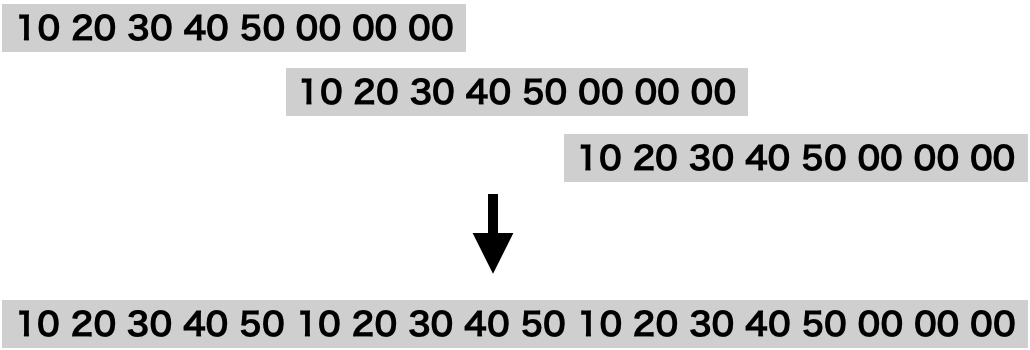">

まずは素朴な実装。

In [156]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 100_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }

    let mut buf: [u8; 5 * SIZE] = [0; 5 * SIZE];

    let start = Instant::now();
    for _ in 0..COUNT {
        for idx in 0..SIZE {
            let v = vs[idx];
            let b = &mut buf[(idx*5)..];
            for i in 0..5 {
                b[i] = (v >> (8 * i)) as u8;
            }
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..5 {
            total += buf[i*5+j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [157]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.50s
     Running `target/release/measure`
21.872 sec
205
63749253


遅い。Go言語よりも遅いです。

内側のforループの展開。

In [152]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 100_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }

    let mut buf: [u8; 5 * SIZE] = [0; 5 * SIZE];

    let start = Instant::now();
    for _ in 0..COUNT {
        for idx in 0..SIZE {
            let v = vs[idx];
            let b = &mut buf[(idx*5)..];
            b[0] = v as u8;
            b[1] = (v >> 8) as u8;
            b[2] = (v >> 16) as u8;
            b[3] = (v >> 24) as u8;
            b[4] = (v >> 32) as u8;
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..5 {
            total += buf[i*5+j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [153]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.52s
     Running `target/release/measure`
21.806 sec
205
63749253


同じです。

関数利用。

In [158]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 100_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }

    let mut buf: [u8; 5 * SIZE] = [0; 5 * SIZE];

    let start = Instant::now();
    for _ in 0..COUNT {
        for idx in 0..SIZE {
            let src = vs[idx].to_le_bytes();
            let b = &mut buf[(idx*5)..];
            b[0] = src[0];
            b[1] = src[1];
            b[2] = src[2];
            b[3] = src[3];
            b[4] = src[4];
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..5 {
            total += buf[i*5+j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [159]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.53s
     Running `target/release/measure`
21.861 sec
205
63749253


同じでした。

最後にポインター利用。

In [160]:
%%writefile src/main.rs
use std::time::Instant;
use rand;
use rand::prelude::*;

fn main() {
    const COUNT: usize = 100_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut vs: [u64; SIZE] = [0; SIZE];
    for i in 0..SIZE {
        vs[i] = rng.gen_range(0..(1<<40));
    }

    let buf: [u8; 5 * SIZE + 3] = [0; 5 * SIZE + 3];

    let start = Instant::now();
    for _ in 0..COUNT {
        for idx in 0..SIZE {
            unsafe {
                *(buf[idx*5..].as_ptr() as *mut u64) = vs[idx];
            }
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );

    // 時間測定外の処理
    println!("{:?}", buf[0]);
    let mut total: usize = 0;
    for i in 0..SIZE {
        for j in 0..5 {
            total += buf[i*5+j] as usize;
        }
    }
    println!("{}", total);
}


Overwriting src/main.rs


In [161]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.51s
     Running `target/release/measure`
6.949 sec
205
63749253


速い。やっとRustの面目躍如。ポインターを使ってやっとGo言語を越せました。

## 5Nバイト配列から40bit整数の配列への変換

> `v = *(ans[idx*5..].as_ptr() as *mut u64) & 0xFF_FFFF_FFFF`が最速

まずは素朴な実装。

In [172]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 100_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut ans:[u8; SIZE*5] = [0; SIZE*5];
    for i in 0..SIZE {
        for j in 0..5 {
            ans[i*5+j] = rng.gen_range(0..256) as u8;
        }
    }
    let mut buf:[u64; SIZE] = [0; SIZE];

    let start = Instant::now();
    for _ in 0..COUNT {
        for i in 0..SIZE {
            let i5 = i * 5;
            let mut v = 0;
            for j in 0..5 {
                v += (ans[i5+j] as u64) << (8 * j);
            }
            buf[i] = v;
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    let mut total: u64 = 0;
    for i in 0..SIZE {
        total += buf[i];
    }

    println!("{}", total);
}

Overwriting src/main.rs


In [173]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.49s
     Running `target/release/measure`
21.323 sec
54987966921384494


内側のforループの展開。

In [174]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 100_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut ans:[u8; SIZE*5] = [0; SIZE*5];
    for i in 0..SIZE {
        for j in 0..5 {
            ans[i*5+j] = rng.gen_range(0..256) as u8;
        }
    }
    let mut buf:[u64; SIZE] = [0; SIZE];

    let start = Instant::now();
    for _ in 0..COUNT {
        for i in 0..SIZE {
            let i5 = i * 5;
            let mut v = ans[i5] as u64;
            v += (ans[i5+1] as u64) << 8;
            v += (ans[i5+2] as u64) << 16;
            v += (ans[i5+3] as u64) << 24;
            v += (ans[i5+4] as u64) << 32;
            buf[i] = v;
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    let mut total: u64 = 0;
    for i in 0..SIZE {
        total += buf[i];
    }

    println!("{}", total);
}

Overwriting src/main.rs


In [175]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.49s
     Running `target/release/measure`
7.901 sec
54987966921384494


めずらしくforループの展開が効果がありました。

関数利用。

In [176]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 100_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut ans:[u8; SIZE*5] = [0; SIZE*5];
    for i in 0..SIZE {
        for j in 0..5 {
            ans[i*5+j] = rng.gen_range(0..256) as u8;
        }
    }
    let mut buf:[u64; SIZE] = [0; SIZE];

    let start = Instant::now();
    for _ in 0..COUNT {
        for i in 0..SIZE {
            let i5 = i * 5;
            buf[i] = u64::from_le_bytes([ans[i5], ans[i5+1], ans[i5+2], ans[i5+3], ans[i5+4], 0, 0, 0]);
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    let mut total: u64 = 0;
    for i in 0..SIZE {
        total += buf[i];
    }

    println!("{}", total);
}

Overwriting src/main.rs


In [177]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.47s
     Running `target/release/measure`
7.885 sec
54987966921384494


変わりません。

別の集計方法。

In [178]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 100_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut ans:[u8; SIZE*5] = [0; SIZE*5];
    for i in 0..SIZE {
        for j in 0..5 {
            ans[i*5+j] = rng.gen_range(0..256) as u8;
        }
    }
    let mut buf:[u64; SIZE] = [0; SIZE];

    let start = Instant::now();
    for _ in 0..COUNT {
        for i in 0..SIZE {
            let i5 = i * 5;
            buf[i] = (u32::from_le_bytes([ans[i5], ans[i5+1], ans[i5+2], ans[i5+3]]) as u64) + ((ans[i5+4] as u64) << 32);
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    let mut total: u64 = 0;
    for i in 0..SIZE {
        total += buf[i];
    }

    println!("{}", total);
}

Overwriting src/main.rs


In [179]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.50s
     Running `target/release/measure`
7.903 sec
54987966921384494


ほぼ同じです。

0xFF_FFFF_FFFFのマスクによる集計方法。

In [180]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 100_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut ans:[u8; SIZE*5] = [0; SIZE*5];
    for i in 0..SIZE {
        for j in 0..5 {
            ans[i*5+j] = rng.gen_range(0..256) as u8;
        }
    }
    let mut buf:[u64; SIZE] = [0; SIZE];

    let start = Instant::now();
    for _ in 0..COUNT {
        for idx in 0..SIZE {
            unsafe {
                buf[idx] = *(ans[idx*5..].as_ptr() as *mut u64) & 0xFF_FFFF_FFFF;
            }
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    let mut total: u64 = 0;
    for i in 0..SIZE {
        total += buf[i];
    }

    println!("{}", total);
}

Overwriting src/main.rs


In [181]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.49s
     Running `target/release/measure`
5.505 sec
54987966921384494


速い。これが最速です。

念のため、

In [182]:
%%writefile src/main.rs
use rand;
use rand::prelude::*;
use std::time::Instant;

fn main() {
    const COUNT: usize = 100_000;
    const SIZE: usize = 100_000;
    let mut rng: rand::rngs::StdRng = rand::SeedableRng::seed_from_u64(0);
    let mut ans:[u8; SIZE*5] = [0; SIZE*5];
    for i in 0..SIZE {
        for j in 0..5 {
            ans[i*5+j] = rng.gen_range(0..256) as u8;
        }
    }
    let mut buf:[u64; SIZE] = [0; SIZE];

    let start = Instant::now();
    for _ in 0..COUNT {
        for idx in 0..SIZE {
            unsafe {
                buf[idx] = (*(ans[idx*5..].as_ptr() as *mut u32) as u64) + ((ans[idx*5+4] as u64) << 32);
            }
        }
    }
    let end = start.elapsed();

    println!(
        "{}.{:03} sec",
        end.as_secs(),
        end.subsec_nanos() / 1_000_000
    );
    let mut total: u64 = 0;
    for i in 0..SIZE {
        total += buf[i];
    }

    println!("{}", total);
}

Overwriting src/main.rs


In [183]:
!cargo run --release

   Compiling measure v0.1.0 (/content/measure)
    Finished release [optimized] target(s) in 0.48s
     Running `target/release/measure`
7.162 sec
54987966921384494


これは遅かった。